<a href="https://colab.research.google.com/github/mhmmdmin/Portfolio/blob/main/AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Load Packages

In [1]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2%}'.format)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind

import statsmodels.api as sm
import scipy.stats as ss
from scipy.stats import chi2_contingency

from dython.nominal import associations

#Load Dataset

In [3]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

In [4]:
def check_missing(df):
  missing = df.isnull().sum()
  per_mis = (missing/len(df))*100
  data_type = df.dtypes
  n_unique = df.nunique()
  return pd.DataFrame({"Missing":missing,
                       "Percent_missing_%": per_mis,
                       "Type":data_type,
                       "Unique Value": n_unique}).sort_values('Percent_missing_%', ascending=False)

#Data Inspection

In [5]:
# Check 1st five rows
raw_data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1


In [6]:
#check missing value, total unique value, and data types
check_missing(raw_data)

,Missing,Percent_missing_%,Type,Unique Value
user_id,0,0.00%,object,350
date_served,0,0.00%,object,31
marketing_channel,0,0.00%,object,5
variant,0,0.00%,object,2
converted,0,0.00%,bool,2
language_displayed,0,0.00%,object,4
language_preferred,0,0.00%,object,4
age_group,0,0.00%,object,7
date_subscribed,0,0.00%,object,31
date_canceled,0,0.00%,object,115


**Change Date Type**

In [7]:
# Change data type
raw_data['date_served'] = pd.to_datetime(raw_data['date_served'])
raw_data['date_subscribed'] = pd.to_datetime(raw_data['date_subscribed'])
raw_data['date_canceled'] = pd.to_datetime(raw_data['date_canceled'])

**Check Unique Value**

In [8]:
# Check unique value
for x in raw_data.columns:
  print(f"unique of {x} ")
  print(f"{raw_data[x].unique()}")
  print()

unique of user_id 
['a100000040' 'a100000041' 'a100000042' 'a100000043' 'a100000044'
 'a100000045' 'a100000046' 'a100000047' 'a100000048' 'a100000059'
 'a100000060' 'a100000061' 'a100000062' 'a100000063' 'a100000064'
 'a100000065' 'a100000066' 'a100000067' 'a100000088' 'a100000089'
 'a100000090' 'a100000091' 'a100000092' 'a100000093' 'a100000094'
 'a100000095' 'a100000096' 'a100000101' 'a100000102' 'a100000103'
 'a100000104' 'a100000105' 'a100000107' 'a100000108' 'a100000109'
 'a100000110' 'a100000164' 'a100000165' 'a100000166' 'a100000167'
 'a100000168' 'a100000169' 'a100000170' 'a100000171' 'a100000172'
 'a100000260' 'a100000261' 'a100000262' 'a100000263' 'a100000264'
 'a100000265' 'a100000266' 'a100000267' 'a100000268' 'a100000294'
 'a100000295' 'a100000296' 'a100000297' 'a100000298' 'a100000299'
 'a100000300' 'a100000301' 'a100000302' 'a100000317' 'a100000318'
 'a100000319' 'a100000320' 'a100000321' 'a100000322' 'a100000323'
 'a100000324' 'a100000325' 'a100000337' 'a100000338' 'a10

From the information above we know that the campaign was only held for 1 month which is in December 2017 - January 2018, and mostly the customers subscribed on the same month. Then, all customers churn which we can see from `is_retained` feature that has only 1 value, False.

In [9]:
#Check data duplicated
raw_data.duplicated().sum()

2

In [10]:
raw_data[raw_data.duplicated(keep=False)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
309,a100000889,2018-01-03,House Ads,control,False,English,English,45-55 years,2018-01-03,2018-03-24,Email,False,0
311,a100000889,2018-01-03,House Ads,control,False,English,English,45-55 years,2018-01-03,2018-03-24,Email,False,0
334,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,0
336,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,0


In [11]:
#Drop duplicates
raw_data.drop_duplicates(inplace=True, ignore_index=True)

#Data Exploration

In [12]:
colors = ["#1DB954", "#14863c", "#0c341c", "#0c5d2b"]
customPalette = sns.set_palette(sns.color_palette(colors))

In [13]:
#Define function for visualization
def prop(x,y):
  cross_tab_prop = pd.crosstab(index=raw_data[x],
                             columns=raw_data[y],
                             normalize="index")
  cross_tab = pd.crosstab(index=raw_data[x],
                        columns=raw_data[y])
  cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap="Accent", 
                        figsize=(10, 6))
  plt.legend(loc="lower left", ncol=2)
  plt.xlabel(f"{x}")
  plt.xticks(rotation = 30)
  plt.ylabel("Proportion")
  for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
      plt.text(x=n - 0.17,
               y=(y_loc - proportion) + (proportion / 2),
               s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
               color="black",
               fontsize=12,
               fontweight="bold")
  plt.show()
  
def countplot(x):
  plt.figure(figsize=(10,6))
  ax = sns.countplot(data=raw_data, x=x)
  ax.bar_label(ax.containers[0], label_type='edge')
  ax.set(title=f'Total User per {x}')
  plt.xticks(rotation=30)
  plt.ylabel('Count')
  plt.show()

def percent(x):
  p1 = (raw_data[x].value_counts(normalize=True)*100).plot(kind='bar',
                                                           color=colors,
                                                           figsize=(10, 6),
                                                           rot=30, 
                                                           ylabel='Percentage',
                                                           title=f'Percentage of User per {x}')

  for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')

##Total User per Marketing Channel

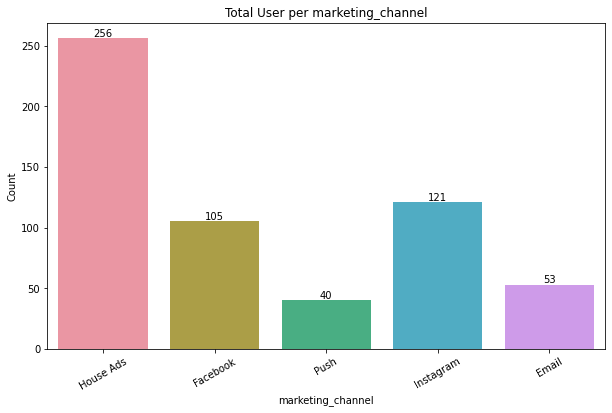

In [14]:
countplot('marketing_channel')

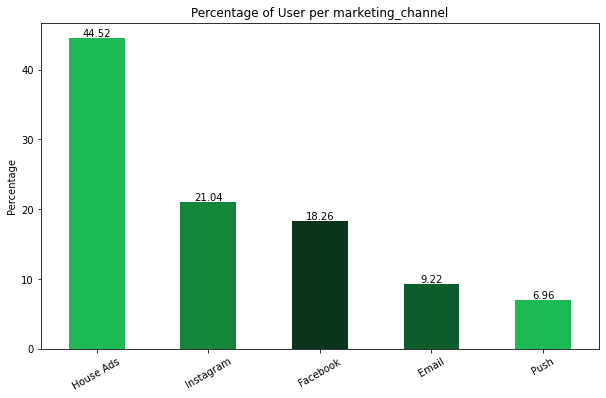

In [15]:
percent("marketing_channel")

House Ads is the most used marketing channel with **44.71%** (256 customers). Followed by Instagram with **20.97%** (121 customers). Then, Facebook with **18.2%** (105 customers). The last two are Email and Push Notification with **9.19%** (53 customers) and **6.93%** (40 customers). 

##Total User per Variant

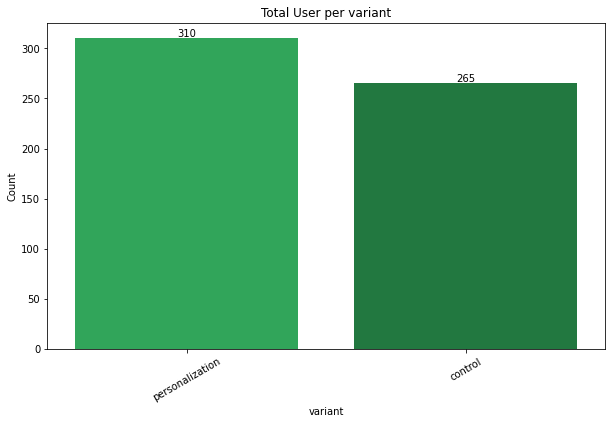

In [16]:
countplot("variant")

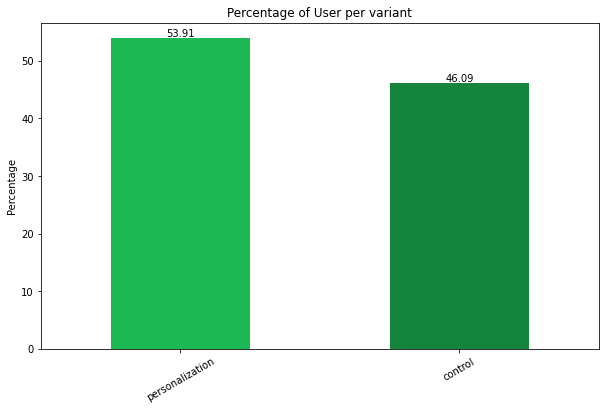

In [17]:
percent("variant")

From the visualization we know that the data has difference around 7% (45 users) between variant and control group. But it's not too significant so we can accept that.

## Total User Converted per Variant##

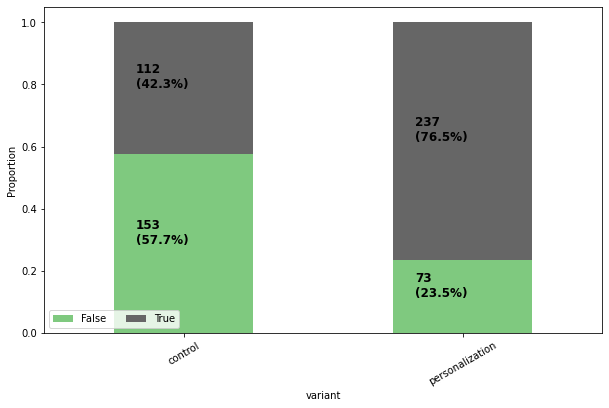

In [18]:
prop('variant','converted')

The conversion rate between control and personalization from the plot above seems significant. The conversion rate for personalization group almost **76.5%** (237 users) from its population and control group only **41.9%** (112 users) from its population. From this plot, we also know that the treatment is seemed having an impact on conversion.

##Total User Converted per Variant from Time to Time

In [19]:
#Create week based column
raw_data['week_subscribed'] = raw_data['date_subscribed'].dt.isocalendar().week

raw_data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion,week_subscribed
0,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,False,1,1
1,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,False,1,1
2,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,False,1,1
3,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,False,1,1
4,a100000044,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-03-03,House Ads,False,1,1


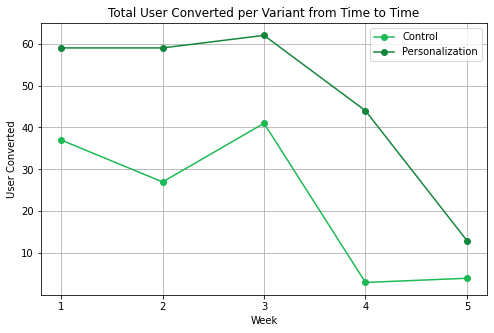

In [20]:
pd.pivot_table(raw_data,index="week_subscribed",columns="variant",values="conversion",
               aggfunc='sum').plot(figsize=(8,5), marker='o')

plt.title('Total User Converted per Variant from Time to Time')
plt.ylabel('User Converted')
plt.xlabel('Week')
plt.legend(['Control','Personalization'], loc = 0)
plt.xticks([1,2,3,4,5])
plt.grid(True);

**Total user converted seems to decrease time to time for both control and treated variant.**

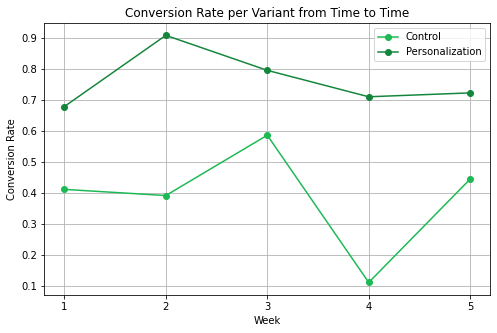

In [21]:
pd.pivot_table(raw_data,index="week_subscribed",columns="variant",values="conversion",
               aggfunc='mean').plot(figsize=(8,5), marker='o')

plt.title('Conversion Rate per Variant from Time to Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Week')
plt.legend(['Control','Personalization'], loc = 0)
plt.xticks([1,2,3,4,5])
plt.grid(True);

**But during the experimental period, it can be concluded from the graph above that treated variant seems to have an uptrend on the second week until 90% and then the trend is going down till the fourth week reach 70% conversion rate. After that the trend is stagnant. For control variant, it seems fluctuative.**

##Total User Converted per Age Group

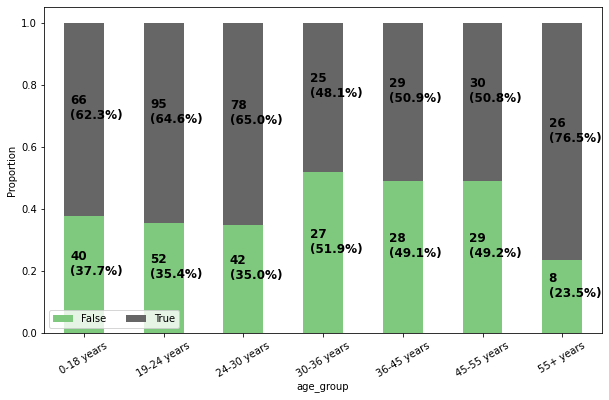

In [22]:
prop("age_group", "converted")

Age group 55+ years has the most conversion rate which is 76.5% even though it has the smallest number of total user (around 26 users converted). Followed by 24-30 years (78 users converted), 19-24 years (95 users converted), and 0-18 years (66 users converted) with conversion rate around 62-65%.

##Correlation between Preferred Language and Conversion

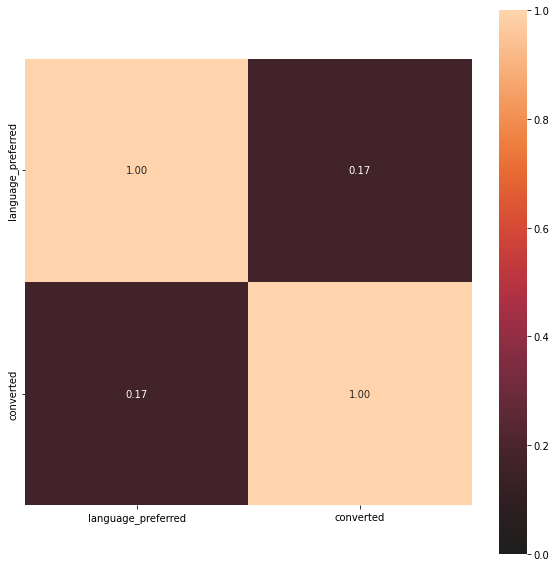

In [23]:
selected_col = raw_data[['language_preferred', 'converted']]
corr = associations(selected_col, filename= 'language_correlation.png', figsize=(10,10))

I am using associations function from dyhton package to find out the correlation between language preferred and conversion. And the result is:

**The correlation between language preferred and conversion seems too weak which is only 17%.**

#Proportion Test (Chi-Square)

In [24]:
conv_calculation = raw_data.groupby(
    ['variant', 'converted'], as_index = False
).size().pivot(
    index='variant', columns = "converted", values = "size"
).reset_index().assign(
    conv_percent = lambda x: x[True] / (x[True] + x[False])
).assign(
    total_sample = lambda x: x[True] + x[False]
)

**The Result**

In [25]:
conv_calculation

converted,variant,False,True,conv_percent,total_sample
0,control,153,112,42.26%,265
1,personalization,73,237,76.45%,310


In [26]:
conv_A = conv_calculation[conv_calculation['variant'] == 'control']['conv_percent'].values
conv_B = conv_calculation[conv_calculation['variant'] == 'personalization']['conv_percent'].values

In [27]:
print((conv_B - conv_A)*100/conv_A)

[80.88997696]


**From the descriptive value above that there are 80% uplift of B compared to A**

##Chi Square Test

In [28]:
# find number of succession
success = conv_calculation[['total_sample', True]].values[:,1]
# find number of all observations
obs = conv_calculation[['total_sample', True]].values[:,0]

In [29]:
result = proportions_chisquare(success, obs)

In [30]:
# Calculate chi squared result
print('X-squared: %.3f' % result[0])
print('p-value: %.3f' % result[1])

X-squared: 69.996
p-value: 0.000


**Interpretation**

- Variant control has 112 conversions compared to variant personalization which has 237 conversions
- Relative uplift of variant personalization (76.45% conversion rate) from variant control (42.26% conversion rate) around 80.9%
- p-value computed is 0.000 < 0.05, hence there is strong statistical significance in test results. It means that treatment had an impact on conversion rate. Then, we should reject null hypothesis and create personalization ads for all users


#Linear Models

In [31]:
# select variant and converted columns
data_for_model = raw_data[['variant', 'converted']].copy()
# create dummy variables and remove first category ('variant_control')
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
# check the first 5 rows
data_for_model.head()

,const,converted,variant_personalization
0,100.00%,True,1
1,100.00%,True,1
2,100.00%,True,1
3,100.00%,True,1
4,100.00%,True,1


In [33]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['converted'], data_for_model[['variant_personalization','const']]).fit()

Optimization terminated successfully.
         Current function value: 0.608179
         Iterations 5


In [34]:
# check model summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                  575
Model:                          Logit   Df Residuals:                      573
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                 0.09239
Time:                        09:23:15   Log-Likelihood:                -349.70
converged:                       True   LL-Null:                       -385.30
Covariance Type:            nonrobust   LLR p-value:                 3.232e-17
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
variant_personalization     1.4895      0.183      8.153      0.000       1.131       1.848
const                      -0.3119      0.124     -2.508      0.012      -0.556      -0.068
===========================================================================================
"""

**Interpretation**

- We don't have to see the Pseudo R-squ because we only focus on the effect of treatment by looking at the P-value
- We can observe uplift of variant B around 148%
- Based on p-value = 0.000 < alpha = 0.05, hence there is strong statistical significance in test results. It means the treatment ads which is personalization had a positive impact on conversion rate. Then, we should reject null hypothesis and create personalization ads for all users.


#Recommendations


---



1.   Create more personalization ads for customers especially social media and email marketing channel which aim age group 0-30 years that also has high conversion rate after age 55+ years.
2.   Collecting more customer data and leveraging it to improve services that can outperform the competitor. For example, by collecting recently listened songs which have lots of spending time , we can create a "Your New Favorite" playlist for them.
3. Not only focusing on services, but also improving products by collaborating with other apps in order to gain innovative engagement and decrease the churn rate

